# W0WaCDM MODEL

Analogamente a quando fatto per LambdaCMD model:
Steps:
* 1- Set the cosmology: H0=67.5, ombh2=0.022, omch2=0.122, omk=0, omrh2= 2.47*10^-5(this values is taken from the internet), omega_Lambda = 0.681   * 
* 2- Compute the distances modulus for each redshifts z took by the file "binned_data" (40 values)
* 3- Compute the chi square and verify that is equal to 0 (or so close to 0)
* 4- Make the best fit with minimize to find the parameters

*N.B: ombh2 = (barion density)*h^2; omch2 = (cold dark matter density)^2; omk = curvature density (these values is taken by CAMB's Tutorial)
*N.B: ombh2 + omch2 = 0.144 --> 0.144/(0.672)**2 = 0.319 (omega_matter)

In [122]:
import sys
sys.path.append("../")

import numpy as np
import math as m
from scipy.optimize import minimize
import sys
import platform
import os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import camb
import pandas as pd

# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa, Dc_w

from scipy.optimize import minimize #to make best fit of the chi square

In [123]:
# READ THE DATA
# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

In [124]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz

# Set the cosmology
H0 = 67.5
omega_matter = 0.319
omega_rad = 2.47e-5/(0.672)**2 # 0.00005 
omega_k = 0
omega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k
w0 = -0.5
wa = -1.3

In [125]:
# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z_list = data['zcmb'].values



mu = []
for z_prime in z_list:
    mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25) #mu.append(5*np.log10(Dc(hubble_function,z_prime,0.319,0,-1,68)*(1+z_prime)) + 25)
#print(mu)
'''
# Plot mu vs z (to verify that the distances are right)
plt.plot(z_list, mu, 'o')
plt.xlabel('Redshift z')
plt.ylabel('Distance Modulus mu')
plt.title('Distance Modulus vs Redshift')
plt.show()
'''
data['mb'] = mu
# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa = params 
    #print(H0, Om0)
    # Check if the parameters are within the physical range
    if Omega_mat or Omega_rad or Omega_k or Omega_L < 0:
        return -np.inf
    if w0 < -2 or w0 > 0:
        return -np.inf
    if wa < -3 or wa > 0:
        return -np.inf
    z = data['zcmb'].values
    d = data['mb'].values 
    mu = []
    for z_prime in z_list:
        mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


In [126]:
# Example data and covariance inverse matrix
z = data['zcmb'].values
d = data['mb'].values + 19.3
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [67.5, 0.319, 0.00005, 0, 0.681, -0.5, -1.3]
print("neg_Ln_likelihood is:", neg_ln_likelihood(initial_guess, data, np.linalg.inv(np.diag(dmb**2))))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
#print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}, w0 = {optimized_params[5]}, wa = {optimized_params[6]}")
print(result)

2024-07-25 18:59:35.415175 :: pyACC.CosmologicalDistances  :: neg_Ln_likelihood is: inf


/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:3600: RuntimeWarning: invalid value encountered in subtract
  if (fx2 - fval) > delta:
/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:3610: RuntimeWarning: invalid value encountered in subtract
  if 2.0 * (fx - fval) <= bnd:


2024-07-25 18:59:35.640050 :: pyACC.CosmologicalDistances  :: Optimized Parameters: [ 6.75e+01  3.19e-01  5.00e-05  0.00e+00  6.81e-01 -5.00e-01 -1.30e+00]
2024-07-25 18:59:35.640455 :: pyACC.CosmologicalDistances  :: Optimized Log Likelihood: -inf
2024-07-25 18:59:35.640600 :: pyACC.CosmologicalDistances  :: Best fit parameters: H0 = 67.5, Omega_matter = 0.319, Omega_rad = 5e-05, Omega_k = 0.0, Omega_L = 0.681, w0 = -0.5, wa = -1.3
2024-07-25 18:59:35.640678 :: pyACC.CosmologicalDistances  ::  message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 1
     fun: inf
       x: [ 6.750e+01  3.190e-01  5.000e-05  0.000e+00  6.810e-01
           -5.000e-01 -1.300e+00]
     nit: 318
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 7000


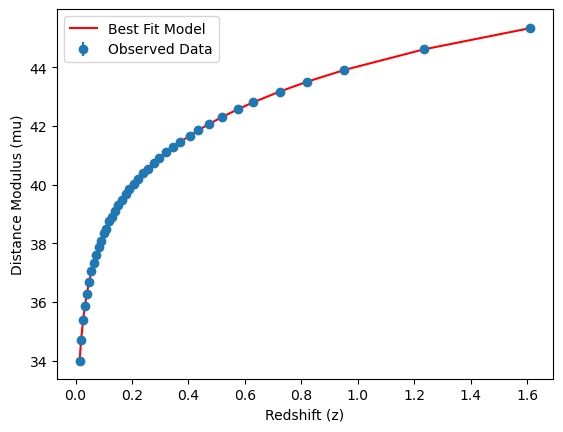

In [127]:
# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best = optimized_params
mu_best = []
for z_prime in z_list:
    mu_best.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best, H0_best)*(1+z_prime)) + 25)

# mb is mu +19.3, so:
y = data['mb'].values # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z_list, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()

# End of the first part

Now I want to study the data file "binned_data.txt" in more detail. To do this I will copy the previous code but in the Likelihood we put mb as the data (and not my computed distances)

N.B: First of all I will study with the simplified Likelihood (only Gaussian part --> Chi Square)

N.B: Then we will study with the complete Likelihood

In [128]:
# Cancel the previous data (in this way we can use mb and not mu)
data = []
d = []
z_list = []
dmb = []

# READ THE DATA
# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

In [129]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz

'''
# Set the cosmology
H0 = 67.5
omega_matter = 0.319
omega_rad = 2.47e-5/(0.672)**2 # 0.00005 
omega_k = 0
omega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k
w0 = -0.5
wa = -1.3
'''

'\n# Set the cosmology\nH0 = 67.5\nomega_matter = 0.319\nomega_rad = 2.47e-5/(0.672)**2 # 0.00005 \nomega_k = 0\nomega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k\nw0 = -0.5\nwa = -1.3\n'

In [130]:
# Extract relevant columns
#d = data['mb'].values
#dmb = data['dmb'].values
#z_list = data['zcmb'].values
'''
mu = []
for z_prime in z_list:
    mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25) #mu.append(5*np.log10(Dc(hubble_function,z_prime,0.319,0,-1,68)*(1+z_prime)) + 25)
'''
# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa = params 
    #print(H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa)
    # Check if the parameters are within the physical range
    if Omega_mat and Omega_rad and Omega_k and Omega_L < 0: #METTERE OR e METTERE PIU IF
        return -np.inf
    if w0 < -2 or w0 > 0:
        return -np.inf
    if wa < -3 or wa > 0:
        return -np.inf
    if H0 < 0 and H0 > 100:
        return -np.inf
    d = data['mb'].values + 19.3
    mu = []
    for z_prime in z_list:
        mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff 
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


In [131]:
# Example data and covariance inverse matrix
d = data['mb'].values + 19.3
dmb = data['dmb'].values
z_list = data['zcmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [67.5, 0.319, 0.00005, 0., 0.681, -0.5, -1.3]
print("neg_Ln_likelihood is:", neg_ln_likelihood(initial_guess, data, np.linalg.inv(np.diag(dmb**2))))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
#print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}, w0 = {optimized_params[5]}, wa = {optimized_params[6]}")
print(result)

2024-07-25 18:59:36.236286 :: pyACC.CosmologicalDistances  :: neg_Ln_likelihood is: 299.4678395259778


KeyboardInterrupt: 

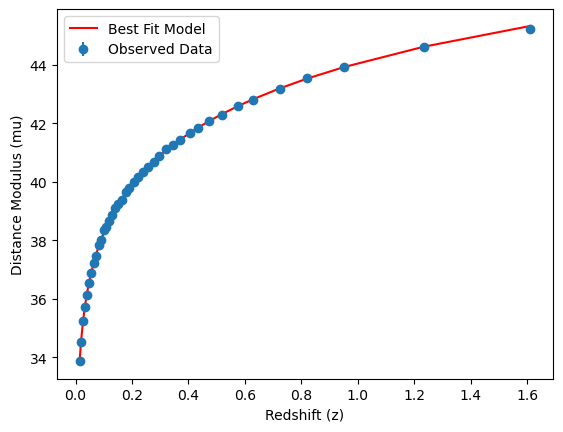

In [ ]:
# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best = optimized_params
mu_best = []
for z_prime in z_list:
    mu_best.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best, H0_best)*(1+z_prime)) + 25)

# mb is mu +19.3, so:
y = data['mb'].values + 19.3 # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z_list, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()

Now, I try to do the same thing but I will change redshifts, i.e. I will take the file with more data: "lcparam_full_long" and then we will do 2 cases:

* 1- I will choose only redshifts smaller than 0.3
* 2- I will choose only redshifts greater than 0.3

With this method we can understand if it is convenient observ Supernovae at low or high redshift

# At low redshift (< 0.3)

In [ ]:
# Cancel the previous data (in this way we can use mb and not mu)
data = []
d = []
z_list = []
dmb = []

# READ THE DATA
# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

In [ ]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz

'''
# Set the cosmology
H0 = 67.5
omega_matter = 0.319
omega_rad = 2.47e-5/(0.672)**2 # 0.00005 
omega_k = 0
omega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k
w0 = -0.5
wa = -1.3
'''

'\n# Set the cosmology\nH0 = 67.5\nomega_matter = 0.319\nomega_rad = 2.47e-5/(0.672)**2 # 0.00005 \nomega_k = 0\nomega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k\nw0 = -0.5\nwa = -1.3\n'

Now I will red the file "lcparam_full_long" and create 2 files: "lcparam_z_low", "lcaparam_z_high" where I put the data with z > 0.3 and the data with z < 0.3

In [ ]:
# Extract relevant columns (i want to take only redshifts greater than 0.3)
name = data['name']
zcmb = data['zcmb'].values
zhel = data['zhel'].values
dz = data['dz'].values
mb = data['mb'].values
dmb = data['dmb'].values
x1 = data['x1'].values
dx1 = data['dx1'].values
color = data['color'].values
dcolor = data['dcolor'].values
rdvar = data['3rdvar'].values
d3rdvar = data['d3rdvar'].values
cov_m_s = data['cov_m_s'].values
cov_m_c = data['cov_m_c'].values
cov_s_c = data['cov_s_c'].values
set = data['set'].values
ra = data['ra'].values
dec = data['dec'].values
#biascor = data['biascor'].values

f1 = open("lcparam_z_low.txt","w")
f2 = open("lcparam_z_high.txt","w")

f1.write("#name zcmb zhel dz mb dmb x1 dx1 color dcolor 3rdvar d3rdvar cov_m_s cov_m_c cov_s_c set ra dec biascor"+"\n")
f2.write("#name zcmb zhel dz mb dmb x1 dx1 color dcolor 3rdvar d3rdvar cov_m_s cov_m_c cov_s_c set ra dec biascor"+"\n")

for i in range(len(zcmb)):
    if zcmb[i] < 0.3:
        f1.write(str(name[i]) + "  " + str(zcmb[i]) + " " + str(zhel[i]) + " " + str(dz[i]) + " " + str(mb[i]) + " " + str(dmb[i]) + " " + str(x1[i]) + " " + str(dx1[i]) + " " + str(color[i]) + " " + str(dcolor[i]) + " " + str(rdvar[i]) + " " + str(d3rdvar[i]) + " " + str(cov_m_s[i]) + " " + str(cov_m_c[i]) + " " + str(cov_s_c[i]) + " " + str(set[i]) + " " + str(ra[i]) + " " + str(dec[i]) + "\n" )
        
    else:
        f2.write(str(name[i]) + "  " + str(zcmb[i]) + " " + str(zhel[i]) + " " + str(dz[i]) + " " + str(mb[i]) + " " + str(dmb[i]) + " " + str(x1[i]) + " " + str(dx1[i]) + " " + str(color[i]) + " " + str(dcolor[i]) + " " + str(rdvar[i]) + " " + str(d3rdvar[i]) + " " + str(cov_m_s[i]) + " " + str(cov_m_c[i]) + " " + str(cov_s_c[i]) + " " + str(set[i]) + " " + str(ra[i]) + " " + str(dec[i]) + "\n" )
        
f1.close()
f2.close()

#Now I read the file: 'lcparam_z_low.txt' with pandas

# READ THE DATA
# Load the data
file_path = 'lcparam_z_low.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data_low = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data_low.columns = header.split()

In [ ]:
# Define the likelihood
z_low = data_low['zcmb'].values
'''
mu_low = []
for z_prime in z_low:
    mu_low.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25)

print(len(z_low)) # 630, 392
print(len(mu_low))
'''

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa = params 
    #print(H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa)
    # Check if the parameters are within the physical range
    if Omega_mat < 0:
        return -np.inf
    if Omega_rad < 0:
        return -np.inf
    if Omega_k < 0:
        return -np.inf
    if Omega_L < 0:
        return -np.inf
    if w0 < -2 or w0 > 0:
        return -np.inf
    if wa < -3 or wa > 0:
        return -np.inf
    if H0 < 0 and H0 > 100:
        return -np.inf
    d = data['mb'].values + 19.3
    mu_low = []
    for z_prime in z_low:
        mu_low.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu_low
    term1 = -0.5 * diff @ cov_inv @ diff 
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


In [ ]:
# Example data and covariance inverse matrix
#d = data['mb'].values + 19.3
dmb_low = data_low['dmb'].values
#z_list = data['zcmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb_low**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [67.5, 0.319, 0.00005, 0., 0.681, -0.5, -1.3]
print("neg_Ln_likelihood is:", neg_ln_likelihood(initial_guess, data_low, cov_inv))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data_low, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
#print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}, w0 = {optimized_params[5]}, wa = {optimized_params[6]}")
print(result)

2024-07-25 18:58:23.239814 :: pyACC.CosmologicalDistances  :: 67.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:26.221800 :: pyACC.CosmologicalDistances  :: neg_Ln_likelihood is: 891.6811031936528
2024-07-25 18:58:26.222855 :: pyACC.CosmologicalDistances  :: 67.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:28.791075 :: pyACC.CosmologicalDistances  :: 67.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:31.341179 :: pyACC.CosmologicalDistances  :: 68.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:33.843264 :: pyACC.CosmologicalDistances  :: 70.118034 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:36.731000 :: pyACC.CosmologicalDistances  :: 69.77642049274198 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:39.376816 :: pyACC.CosmologicalDistances  :: 69.2888712628113 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:42.170100 :: pyACC.CosmologicalDistances  :: 69.59019326358228 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:58:45.074350 :: pyACC.CosmologicalDistances  :: 6

KeyboardInterrupt: 

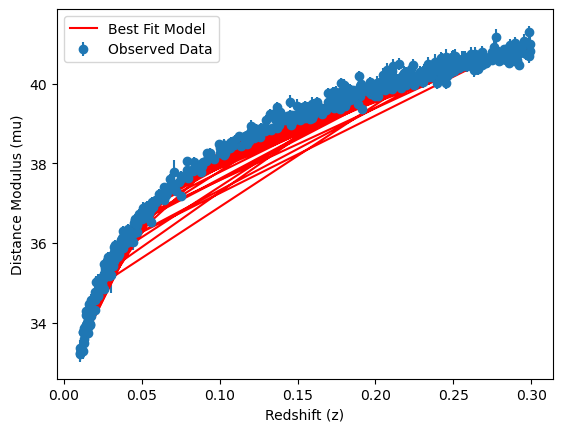

In [ ]:
# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best = optimized_params
mu_best = []
for z_prime in z_low:
    mu_best.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best, H0_best)*(1+z_prime)) + 25)

# mb is mu +19.3, so:
y = data_low['mb'].values + 19.3 # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z_low, y, yerr=data_low['dmb'], fmt='o', label='Observed Data')
plt.plot(z_low, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()

# At high redshift (z > 0.3)

In [ ]:
# READ THE DATA
# Load the data
file_path = 'lcparam_z_high.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data_high = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data_high.columns = header.split()

In [ ]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz

'''
# Set the cosmology
H0 = 67.5
omega_matter = 0.319
omega_rad = 2.47e-5/(0.672)**2 # 0.00005 
omega_k = 0
omega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k
w0 = -0.5
wa = -1.3
'''

'\n# Set the cosmology\nH0 = 67.5\nomega_matter = 0.319\nomega_rad = 2.47e-5/(0.672)**2 # 0.00005 \nomega_k = 0\nomega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k\nw0 = -0.5\nwa = -1.3\n'

In [ ]:
# Define the likelihood
z_high = data_high['zcmb'].values
'''
mu_low = []
for z_prime in z_high:
    mu_low.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25)

print(len(z_high)) # 630, 392
print(len(mu_high))
'''

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa = params 
    print(H0, Omega_mat, Omega_rad, Omega_k, Omega_L, w0, wa)
    # Check if the parameters are within the physical range
    if Omega_mat < 0:
        return -np.inf
    if Omega_rad < 0:
        return -np.inf
    if Omega_k < 0:
        return -np.inf
    if Omega_L < 0:
        return -np.inf
    if w0 < -2 or w0 > 0:
        return -np.inf
    if wa < -3 or wa > 0:
        return -np.inf
    if H0 < 0 and H0 > 100:
        return -np.inf
    d = data['mb'].values + 19.3
    mu_high = []
    for z_prime in z_high:
        mu_high.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, omega_matter, omega_rad, omega_k, omega_L, w0, wa, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu_high
    term1 = -0.5 * diff @ cov_inv @ diff 
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


In [ ]:
# Example data and covariance inverse matrix
#d = data['mb'].values + 19.3
dmb_high = data_high['dmb'].values
#z_list = data['zcmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb_high**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [67.5, 0.319, 0.00005, 0., 0.681, -0.5, -1.3]
print("neg_Ln_likelihood is:", neg_ln_likelihood(initial_guess, data_high, cov_inv))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data_high, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
#print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}, w0 = {optimized_params[5]}, wa = {optimized_params[6]}")
print(result)

2024-07-25 18:50:46.496122 :: pyACC.CosmologicalDistances  :: 67.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:47.500466 :: pyACC.CosmologicalDistances  :: neg_Ln_likelihood is: 371.2794063829969
2024-07-25 18:50:47.500896 :: pyACC.CosmologicalDistances  :: 67.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:48.628984 :: pyACC.CosmologicalDistances  :: 67.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:49.665283 :: pyACC.CosmologicalDistances  :: 68.5 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:50.757592 :: pyACC.CosmologicalDistances  :: 65.881966 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:51.790776 :: pyACC.CosmologicalDistances  :: 66.881966025156 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:52.807068 :: pyACC.CosmologicalDistances  :: 66.50000001554726 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:53.813236 :: pyACC.CosmologicalDistances  :: 67.12583802260521 0.319 5e-05 0.0 0.681 -0.5 -1.3
2024-07-25 18:50:54.858191 :: pyACC.CosmologicalDistances  :: 67

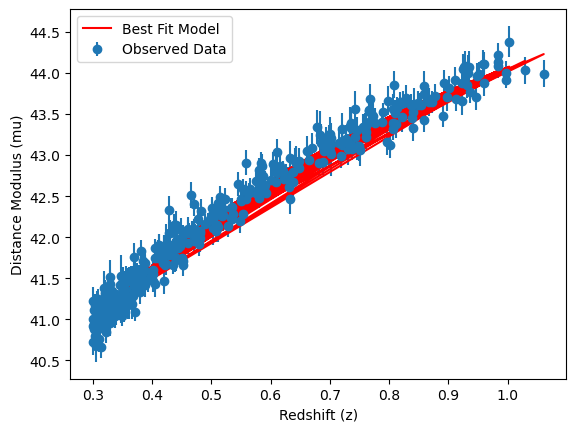

In [ ]:
# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best = optimized_params
mu_best = []
for z_prime in z_high:
    mu_best.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, w0_best, wa_best, H0_best)*(1+z_prime)) + 25)

# mb is mu +19.3, so:
y = data_high['mb'].values + 19.3 # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z_high, y, yerr=data_high['dmb'], fmt='o', label='Observed Data')
plt.plot(z_high, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()